In [15]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
from collections import defaultdict
import numpy as np
from tensorflow.keras.utils import to_categorical
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
import cv2

**LOADING THE IMAGES**

In [2]:
image_dir = 'dataset/images'
annotation_dir = 'dataset/annotations'

data=[]

for filename in os.listdir(annotation_dir):
    tree = ET.parse(os.path.join(annotation_dir, filename))
    root = tree.getroot()

    name = root[1].text
    label = root[4][0].text
    data.append((name, root[4][0].text))

**FILTERING THE IMAGES**

In [3]:
class_images = defaultdict(list)
for image, classname in data:
    class_images[classname].append((image, classname))

filtered_data=[]
for classname, images in class_images.items():
    filtered_data.extend(images[:61])

**CONVERTING TO ARRAYS AND SHUFFLING**

In [4]:
images=[]
labels=[]
count=0
for image_name, class_name in filtered_data:
    """
    try:
        image = cv2.imread(image_name)
        image = cv2.resize(image, (4, 4))
        images.append(image)
    except:
        count+=1
        print(image_name, " didn't work: ", count)
        continue
    """
    image = cv2.imread("dataset/images/"+image_name)
    image = cv2.resize(image, (128, 128))
    images.append(image)
    labels.append(class_name)

images = np.array(images)
labels = np.array(labels)

images, labels = shuffle(images, labels, random_state=42)

**NORMALIZING & FLATTENING IMAGES**

In [5]:
images = images / 255.0

In [85]:
images = images.reshape(len(images), -1).astype("float32")

In [6]:
images.shape

(244, 128, 128, 3)

**ENCODE LABELS**

In [7]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [9]:
labels_encoded

array([3, 3, 0, 2, 2, 0, 2, 0, 3, 1, 3, 2, 1, 0, 1, 0, 2, 3, 1, 0, 3, 3,
       1, 3, 2, 1, 3, 1, 0, 0, 1, 2, 3, 3, 3, 1, 1, 2, 0, 2, 1, 0, 1, 3,
       2, 1, 0, 3, 2, 2, 2, 1, 0, 1, 3, 1, 0, 2, 0, 2, 0, 1, 0, 2, 1, 1,
       1, 1, 2, 0, 0, 2, 1, 3, 2, 2, 0, 3, 3, 0, 0, 1, 1, 0, 2, 0, 3, 3,
       3, 3, 3, 2, 0, 1, 0, 3, 1, 0, 2, 1, 3, 1, 2, 1, 0, 3, 2, 2, 2, 2,
       3, 3, 1, 3, 1, 0, 0, 0, 1, 1, 0, 0, 1, 3, 0, 1, 3, 1, 0, 0, 3, 2,
       3, 0, 3, 0, 3, 0, 0, 0, 1, 0, 0, 2, 2, 1, 2, 1, 3, 2, 3, 0, 3, 0,
       0, 1, 3, 2, 3, 1, 2, 3, 0, 2, 3, 1, 3, 0, 2, 2, 2, 3, 0, 1, 3, 2,
       3, 0, 1, 1, 1, 2, 2, 1, 3, 3, 3, 2, 0, 3, 0, 1, 2, 0, 2, 2, 1, 3,
       1, 3, 2, 0, 2, 2, 2, 2, 0, 3, 3, 1, 3, 3, 2, 0, 2, 2, 2, 0, 3, 0,
       2, 3, 3, 0, 0, 0, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 3, 2, 1, 1, 3, 1,
       0, 1], dtype=int64)

**ONE-HOT ENCODE LABELS**

In [8]:
labels_one_hot = to_categorical(labels_encoded, num_classes=4)

**SPLITTING INTO TRAINING AND TESTING**

In [10]:
x_train, x_test, y_train, y_test = train_test_split(images, labels_one_hot, test_size=0.1, random_state=42)

**MODEL ARCHITECTURE**

In [11]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.1),
    Dense(4, activation='softmax')
])
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.optimizer.get_config()

{'name': 'Adam',
 'weight_decay': None,
 'clipnorm': None,
 'global_clipnorm': None,
 'clipvalue': None,
 'use_ema': False,
 'ema_momentum': 0.99,
 'ema_overwrite_frequency': None,
 'jit_compile': False,
 'is_legacy_optimizer': False,
 'learning_rate': 1e-04,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

**Train Model**

In [12]:
history = model.fit(x_train, y_train, epochs=25, batch_size=16, validation_data=(x_test, y_test))

Epoch 1/25
14/14 [==============================] - 2s 142ms/step - loss: 1.4127 - accuracy: 0.2557 - val_loss: 1.3995 - val_accuracy: 0.2800
Epoch 2/25
14/14 [==============================] - 2s 133ms/step - loss: 1.3719 - accuracy: 0.2831 - val_loss: 1.3831 - val_accuracy: 0.2800
Epoch 3/25
14/14 [==============================] - 2s 138ms/step - loss: 1.2885 - accuracy: 0.5251 - val_loss: 1.3540 - val_accuracy: 0.4400
Epoch 4/25
14/14 [==============================] - 2s 134ms/step - loss: 1.2123 - accuracy: 0.4612 - val_loss: 1.3102 - val_accuracy: 0.4800
Epoch 5/25
14/14 [==============================] - 2s 134ms/step - loss: 1.0959 - accuracy: 0.6119 - val_loss: 1.2744 - val_accuracy: 0.4800
Epoch 6/25
14/14 [==============================] - 2s 136ms/step - loss: 0.9366 - accuracy: 0.6621 - val_loss: 1.2800 - val_accuracy: 0.3200
Epoch 7/25
14/14 [==============================] - 2s 137ms/step - loss: 0.8298 - accuracy: 0.7397 - val_loss: 1.2350 - val_accuracy: 0.5200
Epoch 

In [13]:
val_loss, val_accuracy = model.evaluate(x_test, y_test)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

1/1 [==============================] - 0s 50ms/step - loss: 1.5285 - accuracy: 0.5200
Validation Loss: 1.5284829139709473
Validation Accuracy: 0.5199999809265137


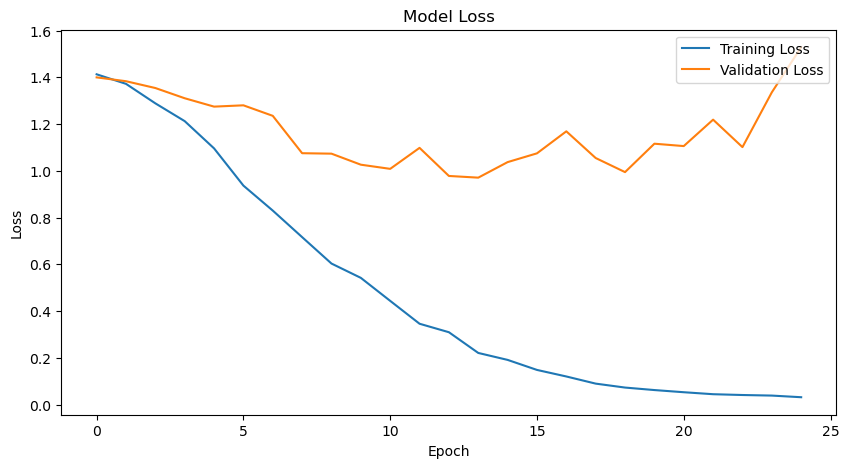

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [14]:
history.history['val_loss']

[1.3994048833847046,
 1.3931989669799805,
 1.2585653066635132,
 1.121938705444336,
 1.1146836280822754,
 1.183718204498291,
 1.2284440994262695,
 1.357500433921814,
 1.2713013887405396,
 2.0859885215759277,
 1.7267193794250488,
 1.0821279287338257,
 1.3167071342468262,
 1.9519060850143433,
 2.2719337940216064,
 1.467850923538208,
 1.4943199157714844,
 1.4251737594604492,
 1.5582307577133179,
 1.7003254890441895,
 1.7834075689315796,
 1.8515081405639648,
 1.8393571376800537,
 1.8229445219039917,
 1.8584932088851929]